In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import h5py

Function to list patient names

In [50]:
def list_patient_names(root):

    patient_list = sorted([item for item in os.listdir(root) 
                           if os.path.isdir(os.path.join(root, item))],
                           key = lambda x: x[4:])
    
    return patient_list

Function to list trial files

In [51]:
def list_trial_files(root, patient_name):
    
    patient_folder = root + patient_name + "/"
    
    trial_names = sorted([f for f in os.listdir(patient_folder) 
                          if os.path.isfile(os.path.join(patient_folder, f))])
    
    return trial_names

Function to read in patient name, patient type, trial number, stimulus type, sensor name

In [52]:
def parse_dat(root, patient_name, trial_file):
    
    txtfile = root + patient_name + "/" + trial_file
    
    # Read in the entire data file
    lines = []

    with gzip.open(txtfile,'rt') as f:
        for line in f:
            lines.append(line)
            
    # Get the patient name
    patient_name = lines[0].split(' ')[1][:-4]
    
    # Get patient type (alcoholic or control)
    patient_type = patient_name[3]
    
    # Get trial number
    trial_num = trial_file[-6:-3]
    
    # Get stimulus type
    stim_type = lines[3].split(' ')[1] + ' ' + lines[3].split(' ')[2]
    
    # Get sensor names
    readings = lines[4:]
    headers = [r for r in readings if r[0]=='#']
    sensor_names = [h.split(' ')[1] for h in headers]
        
    # Get sensor readings for all 64 detectors for all 256 timestamps
    data = [r for r in readings if r[0]!='#']
    
    data_mat = np.zeros((64, 256))
    
    for i in range(64):
        for j in range(256):
            data_mat[i, j] = float(data[i*256+j].split(' ')[3][:-1])
            
    return patient_name, patient_type, trial_num, stim_type, sensor_names, data_mat

Load in training data

In [53]:
root = "/Users/thepoetoftwilight/Documents/UCLA Classes/XIII - Winter 2022/Physics 180M/Final Project/SMNI_CMI_TRAIN/"

In [54]:
patient_list = list_patient_names(root)

In [55]:
df = pd.read_csv(root+'S2_nonmatch_patient_summary.csv')
hf = h5py.File(root+'S2_nonmatch.h5', 'r')

In [56]:
df['Type'] = df['Type'].replace({'c':0, 'a':1})

In [57]:
dat_tensor = np.zeros((len(df), 64, 256))

In [58]:
dat_targets = np.zeros(len(df))

In [59]:
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

In [60]:
train_tensor = dat_tensor
train_target = dat_targets

Construct a neural network

In [61]:
# For constructing the neural network
import tensorflow as tf
from tensorflow import keras

In [62]:
# Input layer
x = keras.layers.Input(shape=(64,256))

# Flatten it
f = keras.layers.Flatten()(x)

# First dense layer
m1 = keras.layers.Dense(25, activation='relu')(f)

# Second dense layer

m2 = keras.layers.Dense(15, activation='relu')(m1)

# Ensure outputs are between 0 and 1 using sigmoid activation
h = keras.layers.Dense(1, activation='sigmoid')(m2)

# Construct Model 
model = keras.models.Model(inputs=x, outputs=h)

# Compile Model
model.compile(optimizer=keras.optimizers.SGD(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [63]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 256)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 25)                409625    
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 410,031
Trainable params: 410,031
Non-trainable params: 0
_________________________________________________________________


Fit the model

In [64]:
history = model.fit(train_tensor, train_target, epochs = 100, 
                    batch_size = 10, 
                    validation_split=.2)

Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 28.0683 - binary_accuracy: 0.5875 - val_loss: 2.4796 - val_binary_accuracy: 0.2500
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0182 - binary_accuracy: 0.6250 - val_loss: 1.2046 - val_binary_accuracy: 0.0750
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.5965 - binary_accuracy: 0.6875 - val_loss: 1.1189 - val_binary_accuracy: 0.0250
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4956 - binary_accuracy: 0.7375 - val_loss: 1.2535 - val_binary_accuracy: 0.0750
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4578 - binary_accuracy: 0.7625 - val_loss: 1.3424 - val_binary_accuracy: 0.0750
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4230 - binary_accuracy: 0.7812 - val_loss: 1.2686 - val_binary_accuracy: 0.0750
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - l

16/16 [==============================] - 0s 6ms/step - loss: 0.1825 - binary_accuracy: 0.9062 - val_loss: 2.8024 - val_binary_accuracy: 0.1250
Epoch 54/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1819 - binary_accuracy: 0.9062 - val_loss: 2.8192 - val_binary_accuracy: 0.1250
Epoch 55/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1816 - binary_accuracy: 0.9062 - val_loss: 2.8422 - val_binary_accuracy: 0.1250
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1813 - binary_accuracy: 0.9062 - val_loss: 2.8614 - val_binary_accuracy: 0.1250
Epoch 57/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1810 - binary_accuracy: 0.9062 - val_loss: 2.8757 - val_binary_accuracy: 0.1250
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1808 - binary_accuracy: 0.9062 - val_loss: 2.8873 - val_binary_accuracy: 0.1250
Epoch 59/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1

Load in testing data

In [65]:
root = "/Users/thepoetoftwilight/Documents/UCLA Classes/XIII - Winter 2022/Physics 180M/Final Project/SMNI_CMI_TEST/"

In [66]:
patient_list = list_patient_names(root)

In [67]:
df = pd.read_csv(root+'S2_nonmatch_patient_summary.csv')
hf = h5py.File(root+'S2_nonmatch.h5', 'r')

In [68]:
df['Type'] = df['Type'].replace({'c':0, 'a':1})

In [69]:
dat_tensor = np.zeros((len(df), 64, 256))

In [70]:
dat_targets = np.zeros(len(df))

In [71]:
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

In [72]:
test_tensor = dat_tensor
test_targets = dat_targets

Evaluate performance

In [73]:
test_target_probs = model.predict(test_tensor).flatten()

In [74]:
c_range = np.linspace(0,1,100)

In [75]:
# Computing the accuracies
accuracies = np.ones(len(c_range))

for i in range(len(c_range)):
    c = c_range[i]
    # Compute accuracy as before but with threshold c
    accuracies[i] = np.sum(1*(test_target_probs>c)
                           ==test_targets)/len(test_targets)

Text(0, 0.5, 'Accuracy')

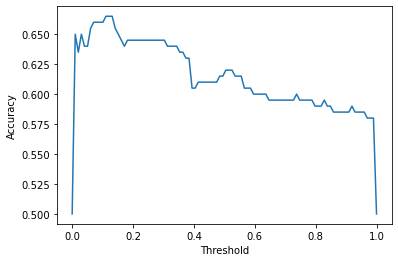

In [76]:
fig, ax = plt.subplots(1)
ax.plot(c_range, accuracies)
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [78]:
preds = np.float_(test_target_probs>c_range[np.argmax(accuracies)])

([<matplotlib.axis.YTick at 0x7ffe1b0583a0>,
 [Text(0, 0, 'Control'), Text(0, 1, 'Alcoholic')])

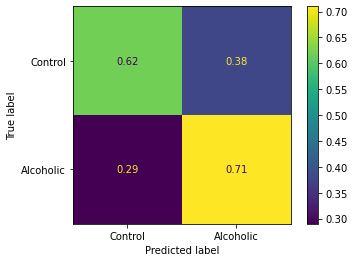

In [79]:
# Obtain the confusion matrix
cm = confusion_matrix(y_true = test_targets, 
                      y_pred = preds, normalize='true')

# Plot it!
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

#fig_path = model_path+'S1-conf_mat.png'
#plt.savefig(fig_path)

plt.xticks(ticks = [0,1], labels=['Control','Alcoholic'])
plt.yticks(ticks = [0,1], labels=['Control','Alcoholic'])

Load and split into training and testing data the full dataset

In [80]:
root = "/Users/thepoetoftwilight/Documents/UCLA Classes/XIII - Winter 2022/Physics 180M/Final Project/eeg_full/"

In [81]:
patient_list = list_patient_names(root)

In [82]:
df = pd.read_csv(root+'S2_nonmatch_patient_summary.csv')
hf = h5py.File(root+'S2_nonmatch.h5', 'r')

In [83]:
df['Type'] = df['Type'].replace({'c':0, 'a':1})

In [84]:
dat_tensor = np.zeros((len(df), 64, 256))

In [85]:
dat_targets = np.zeros(len(df))

In [86]:
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
train_tensor_full, test_tensor_full, train_target_full, test_target_full = train_test_split(
                                            dat_tensor, dat_targets, test_size=0.2, random_state=0)

Evaluate performance over full dataset

In [89]:
test_target_probs = model.predict(test_tensor_full).flatten()

In [90]:
# Computing the accuracies
accuracies = np.ones(len(c_range))

for i in range(len(c_range)):
    c = c_range[i]
    # Compute accuracy as before but with threshold c
    accuracies[i] = np.sum(1*(test_target_probs>c)
                           ==test_target_full)/len(test_target_full)

Text(0, 0.5, 'Accuracy')

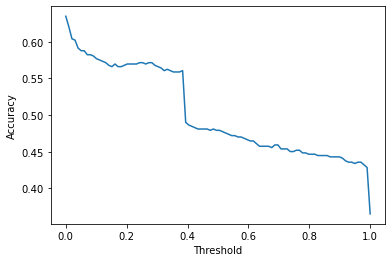

In [91]:
fig, ax = plt.subplots(1)
ax.plot(c_range, accuracies)
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')

In [92]:
preds = np.float_(test_target_probs>c_range[np.argmax(accuracies)])

([<matplotlib.axis.YTick at 0x7ffdfbb37370>,
 [Text(0, 0, 'Control'), Text(0, 1, 'Alcoholic')])

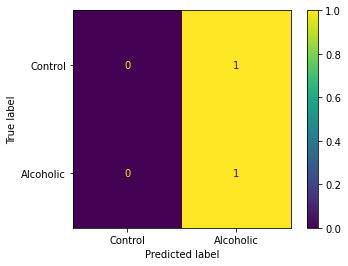

In [93]:
# Obtain the confusion matrix
cm = confusion_matrix(y_true = test_target_full, 
                      y_pred = preds,normalize='true')

# Plot it!
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

#fig_path = model_path+'S1-conf_mat.png'
#plt.savefig(fig_path)

plt.xticks(ticks = [0,1], labels=['Control','Alcoholic'])
plt.yticks(ticks = [0,1], labels=['Control','Alcoholic'])